In [1]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import warnings
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import explained_variance_score
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('winequality-red.csv', sep = ",")
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


<h3 style="font-family: 'Helvetica'"> Расшифровка названий полей датасета.</h3>
<pre style="font-family: 'Helvetica'">
<b>fixed acidity</b> - most acids involved with wine or fixed or nonvolatile (do not evaporate readily)	
<b>volatile acidity</b> - the amount of acetic acid in wine, which at too high of levels can lead to an unpleasant, vinegar taste	
<b>citric acid</b> - found in small quantities, citric acid can add 'freshness' and flavor to wines	
<b>residual sugar</b> - the amount of sugar remaining after fermentation stops, it's rare to find wines with less than 1 gram/liter and wines with greater than 45 grams/liter are considered sweet	
<b>chlorides</b> - the amount of salt in the wine	
<b>free sulfur dioxide</b> - the free form of SO2 exists in equilibrium between molecular SO2 (as a dissolved gas) and bisulfite ion; it prevents microbial growth and the oxidation of wine	
<b>total sulfur dioxide</b> - amount of free and bound forms of S02; in low concentrations, SO2 is mostly undetectable in wine, but at free SO2 concentrations over 50 ppm, SO2 becomes evident in the nose and taste of wine	
<b>density</b> - the density of water is close to that of water depending on the percent alcohol and sugar content	
<b>pH</b> - describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic); most wines are between 3-4 on the pH scale	
<b>sulphates</b> - a wine additive which can contribute to sulfur dioxide gas (S02) levels, wich acts as an antimicrobial and antioxidant	
<b>alcohol</b> - the percent alcohol content of the wine	
<b>quality</b> - output variable (based on sensory data, score between 0 and 10)	
</pre>

<h3 style="font-family: 'Arial'">Проверка наличия пустых ячеек.</h3>

In [3]:
def EmptyReport(ScanData):
    ScanData.isnull().sum()
    DataSize = ScanData.shape
    AttributesNames = []
    EmptyData = []
    EmptyDataPercent = []
    for  i in ScanData:
        AttributesNames.append(i)
        EmptyData.append(ScanData[i].isnull().sum())
        EmptyDataPercent.append(round(ScanData[i].isnull().sum()/DataSize[0]*100,4))
    EmptyData = pd.DataFrame({'Attributes Names':AttributesNames, 
                             'Empty Data':EmptyData, 
                             'Empty Data (%)':EmptyDataPercent})
    return EmptyData

In [4]:
EmptyReport(data)

,Attributes Names,Empty Data,Empty Data (%)
0,fixed acidity,0,0.0
1,volatile acidity,0,0.0
2,citric acid,0,0.0
3,residual sugar,0,0.0
4,chlorides,0,0.0
5,free sulfur dioxide,0,0.0
6,total sulfur dioxide,0,0.0
7,density,0,0.0
8,pH,0,0.0
9,sulphates,0,0.0


<h4 style="font-family: 'Arial'">Пустых значений - нет.</h4>

<h4 style="font-family: 'Arial'">Посмотрим на типы данных.</h4>

In [5]:
data.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

<h3 style="font-family: 'Arial'">Корреляционный анализ</h3>

<h4 style="font-family: 'Arial'">Произведём корреляционный анализ:</h4>

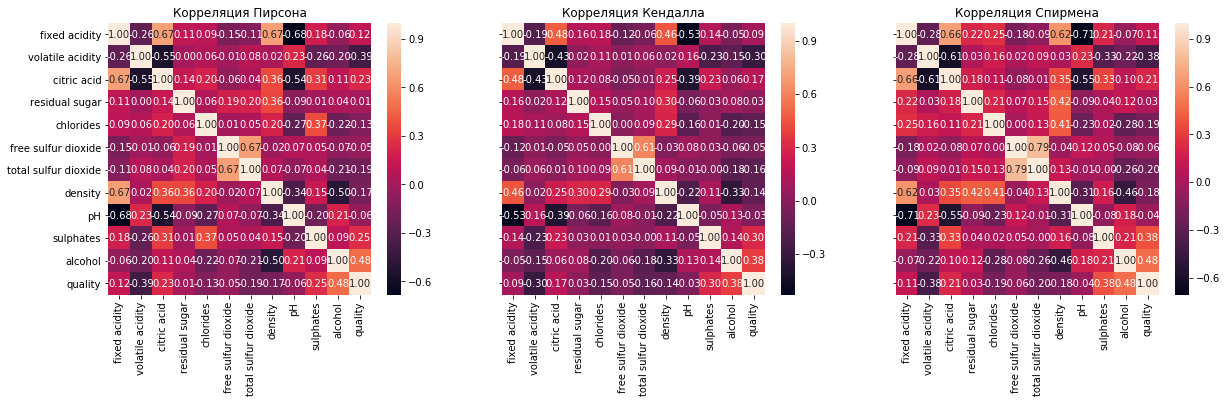

In [6]:
fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(20,5))
sns.heatmap(data.corr(method='pearson'), ax=ax[0], annot=True, fmt='.2f')
sns.heatmap(data.corr(method='kendall'), ax=ax[1], annot=True, fmt='.2f')
sns.heatmap(data.corr(method='spearman'), ax=ax[2], annot=True, fmt='.2f')
ax[0].title.set_text('Корреляция Пирсона')
ax[1].title.set_text('Корреляция Кендалла')
ax[2].title.set_text('Корреляция Спирмена')

<h4 style="font-family: 'Arial'">Рассмотрим зависимости качества от нескольких параметров:</h4>

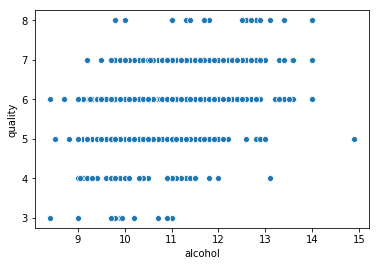

In [7]:
sns.scatterplot(x='alcohol', y='quality', data=data)

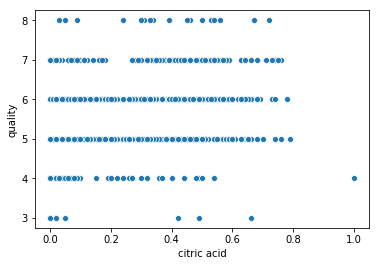

In [8]:
sns.scatterplot(x='citric acid', y='quality', data=data)

<pre style="font-family: 'Arial'">    В качестве моделей машинного обучения будем тиспользовать следующий набор:
        1. Метод К соседей (Библиотека SkikitLearn)
        2. Линейная регессия (Библиотека SkikitLearn)
        3. Метод опорных векторов SVR (Библиотека SkikitLearn)
        4. Метод Градиентного бустинга CatBoostRegressor (Библиотека CatBoost)
        5. Случайный лес (Библиотека SkikitLearn)
</pre>


In [9]:
DataInst = data[['fixed acidity', 'volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol']]
DataTarget = data['quality']
TrainX, TestX, TrainY, TestY = train_test_split(DataInst,DataTarget, test_size=0.3, random_state = 1)

In [10]:
def ModelLearnReport(Model,trainX,trainY,testX,testY):
    Model.fit(trainX,trainY)
    ModelPredict = Model.predict(testX)
    print("Средняя абсолютная ошибка:\t",round(mean_absolute_error(testY, ModelPredict),6))
    print("Средняя квадратичная ошибка:\t",round(mean_squared_error(testY, ModelPredict),6))
    print("Коэффициент детерминации:\t",round(r2_score(testY, ModelPredict),6))
    print("Explained variance score:\t",round(explained_variance_score(testY, ModelPredict),6))

<h3 style="font-family: 'Arial'">Метод К соседей</h3>

In [11]:
from sklearn.neighbors import KNeighborsRegressor
KNeighborsRegressor()

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')

In [12]:
KNNRSP = KNeighborsRegressor(n_neighbors=7) # KNNRSP - K Nearest Neighbors Regressor Standart Parameters
ModelLearnReport(KNNRSP,TrainX,TrainY,TestX,TestY)

Средняя абсолютная ошибка:	 0.565179
Средняя квадратичная ошибка:	 0.551148
Коэффициент детерминации:	 0.094462
Explained variance score:	 0.094661


In [13]:
TuningParameters = [{'n_neighbors':np.array(range(1,16))}]
GS = GridSearchCV(KNeighborsRegressor(), TuningParameters, cv=20, scoring='explained_variance')
GS.fit(DataInst,DataTarget)
print('Подобранный оптимальный гиперпараметр: ', GS.best_params_.get('n_neighbors'))
KNNRGS = KNeighborsRegressor(n_neighbors=GS.best_params_.get('n_neighbors')) 
ModelLearnReport(KNNRGS,TrainX,TrainY,TestX,TestY)

Подобранный оптимальный гиперпараметр:  15
Средняя абсолютная ошибка:	 0.575278
Средняя квадратичная ошибка:	 0.547259
Коэффициент детерминации:	 0.100851
Explained variance score:	 0.101007


<h3 style="font-family: 'Arial'">Линейная регрессия</h3>

In [14]:
from sklearn.linear_model import Lasso
Lasso()

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [15]:
LRSP = Lasso() # LRSP - Linear Regression Standart Parameters
ModelLearnReport(LRSP,TrainX,TrainY,TestX,TestY)

Средняя абсолютная ошибка:	 0.638392
Средняя квадратичная ошибка:	 0.595101
Коэффициент детерминации:	 0.022248
Explained variance score:	 0.027311


In [16]:
TuningParameters = [{'alpha':[0.001,0.01,0.1,1,10,100,1000]}]
GS = GridSearchCV(Lasso(), TuningParameters, cv=20, scoring='explained_variance')
GS.fit(DataInst,DataTarget)
print('Подобранный оптимальный гиперпараметр: ', GS.best_params_.get('alpha'))
LRGS = Lasso(alpha=GS.best_params_.get('alpha')) 
ModelLearnReport(LRGS,TrainX,TrainY,TestX,TestY)

Подобранный оптимальный гиперпараметр:  0.001
Средняя абсолютная ошибка:	 0.4979
Средняя квадратичная ошибка:	 0.413422
Коэффициент детерминации:	 0.320747
Explained variance score:	 0.3246


<h3 style="font-family: 'Arial'">Метод опорных векторов</h3>

In [17]:
from sklearn.svm import LinearSVR
LinearSVR()

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)

In [18]:
LSVRSP = LinearSVR() # LSVRSP - Linear Support Vector Regressor Standart Parameters
ModelLearnReport(LSVRSP,TrainX,TrainY,TestX,TestY)

Средняя абсолютная ошибка:	 0.702309
Средняя квадратичная ошибка:	 0.752893
Коэффициент детерминации:	 -0.237006
Explained variance score:	 0.175186


In [19]:
TuningParameters = [{'C':[0.001,0.01,0.1,1]}]
GS = GridSearchCV(LinearSVR(), TuningParameters, cv=20, scoring='explained_variance')
GS.fit(DataInst,DataTarget)
print('Подобранный оптимальный гиперпараметр: ', GS.best_params_.get('C'))
LSVRGS = LinearSVR(C=GS.best_params_.get('C')) 
ModelLearnReport(LSVRGS,TrainX,TrainY,TestX,TestY)

Подобранный оптимальный гиперпараметр:  0.01
Средняя абсолютная ошибка:	 0.504494
Средняя квадратичная ошибка:	 0.45766
Коэффициент детерминации:	 0.248064
Explained variance score:	 0.253656


<h3 style="font-family: 'Arial'">Случайный лес</h3>

In [20]:
from sklearn.ensemble import RandomForestRegressor
RandomForestRegressor()

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [21]:
RFRSP = RandomForestRegressor(n_estimators=5) # RFRSP - Random Forest Regressor Standart Parameters
ModelLearnReport(RFRSP,TrainX,TrainY,TestX,TestY)

Средняя абсолютная ошибка:	 0.459583
Средняя квадратичная ошибка:	 0.405583
Коэффициент детерминации:	 0.333625
Explained variance score:	 0.33559


In [22]:
TuningParameters = [{'n_estimators':np.array(range(1,50))}]
GS = GridSearchCV(RandomForestRegressor(), TuningParameters, cv=20, scoring='explained_variance')
GS.fit(DataInst,DataTarget)
print('Подобранный оптимальный гиперпараметр: ', GS.best_params_.get('n_estimators'))
RFRGS = RandomForestRegressor(n_estimators=GS.best_params_.get('n_estimators')) 
ModelLearnReport(RFRGS,TrainX,TrainY,TestX,TestY)

Подобранный оптимальный гиперпараметр:  42
Средняя абсолютная ошибка:	 0.430308
Средняя квадратичная ошибка:	 0.333216
Коэффициент детерминации:	 0.452524
Explained variance score:	 0.458336


<h3 style="font-family: 'Arial'">Бустинг</h3>

In [23]:
from sklearn.ensemble import AdaBoostRegressor
AdaBoostRegressor()

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None)

In [24]:
ABRSP = AdaBoostRegressor(n_estimators=10) # RFRSP - Random Forest Regressor Standart Parameters
ModelLearnReport(ABRSP,TrainX,TrainY,TestX,TestY)

Средняя абсолютная ошибка:	 0.521948
Средняя квадратичная ошибка:	 0.402857
Коэффициент детерминации:	 0.338105
Explained variance score:	 0.339262


In [25]:
TuningParameters = [{'n_estimators':np.array(range(1,50))}]
GS = GridSearchCV(AdaBoostRegressor(), TuningParameters, cv=20, scoring='explained_variance')
GS.fit(DataInst,DataTarget)
print('Подобранный оптимальный гиперпараметр: ', GS.best_params_.get('n_estimators'))
ABRGS = AdaBoostRegressor(n_estimators=GS.best_params_.get('n_estimators')) 
ModelLearnReport(ABRGS,TrainX,TrainY,TestX,TestY)

Подобранный оптимальный гиперпараметр:  31
Средняя абсолютная ошибка:	 0.493946
Средняя квадратичная ошибка:	 0.380898
Коэффициент детерминации:	 0.374183
Explained variance score:	 0.381656
